In [20]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals


def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()
    
def cover_ratio(transformed, label): #what part of white pixels were actually covered
    return np.sum(transformed * label)/np.sum(label)

def accuracy(transformed, label):
    return (transformed == label).sum()/(label.shape[1]*label.shape[0])

def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges
 
    
def process_img(img_path, mask_path, label_path):    
    img = cv2.imread(img_path)
    mask = plt.imread(mask_path) #cause cv2 can't read gifs :X
    labeled = plt.imread(label_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    #plot_images(rgb, gray, mask)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hist_eq = clahe.apply(gray)

    gamma = 1.2
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    gamma_corrected = cv2.LUT(hist_eq, table)

    # fast cv2 denoising
    denoised = cv2.fastNlMeansDenoising(gamma_corrected.astype('uint8'), None, 3,7)

    #plot_images(hist_eq, gamma_corrected, denoised)

    a, b = detect_ridges(denoised, sigma=3.0)

    #plot_images(denoised, a, b)

    a = a + (a.min() * (-1)) #just some normalization stuff, because we were going negative
    a = a/a.max()
    a = a*255
    a = a.astype('uint8') # basic conversion for cv2 operations to work properly

    #applying a mask
    masked = np.zeros(a.shape)
    masked[mask > 0] = a[mask > 0]



    median  = cv2.medianBlur(masked.astype('uint8'), 5)


    median = 255-median

    ret,thresh = cv2.threshold(median.astype('uint8'),165,255,cv2.THRESH_BINARY_INV)
    #thresh = cv2.adaptiveThreshold(median.astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #            cv2.THRESH_BINARY_INV,5,2)
    #ret3,th4 = cv2.threshold(median.astype('uint8'),80,90,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    #plot_images(masked, median, thresh)

    plot_images(rgb, thresh, labeled)
    #print(accuracy(thresh, labeled))
    return thresh, labeled, accuracy(thresh, labeled)

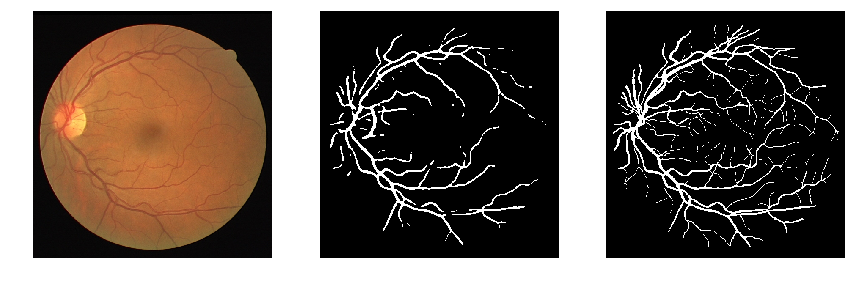

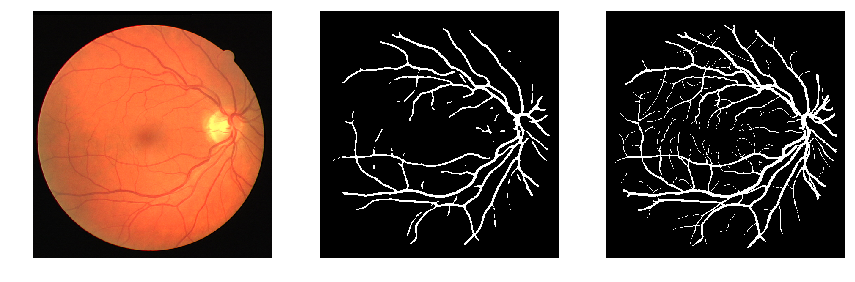

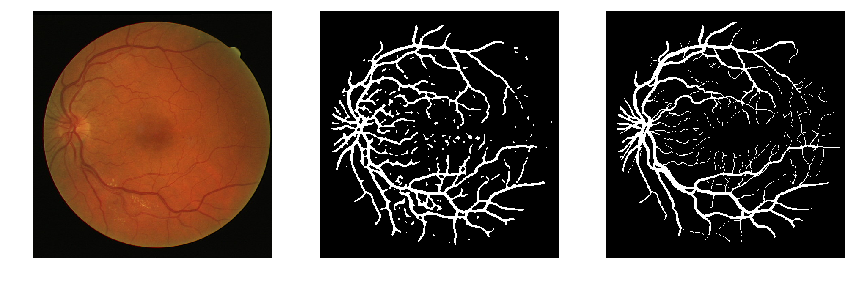

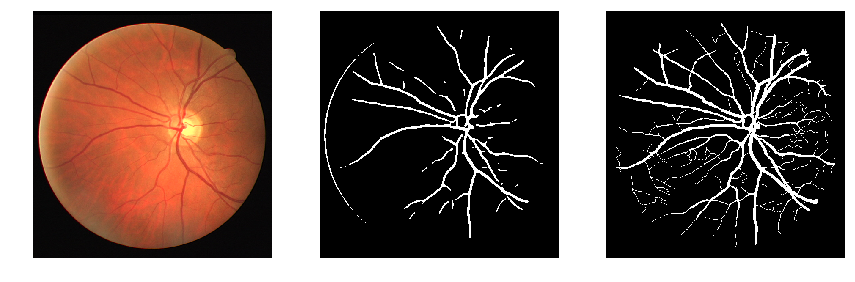

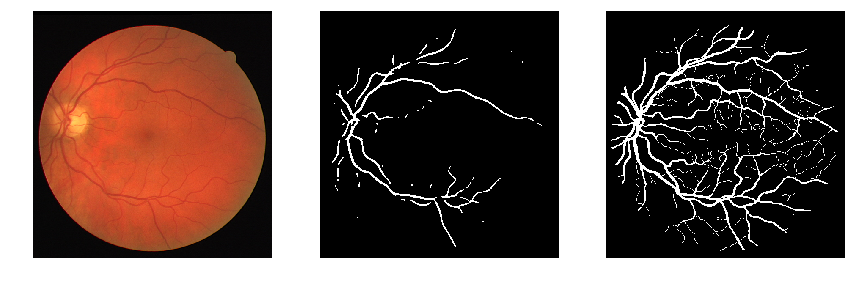

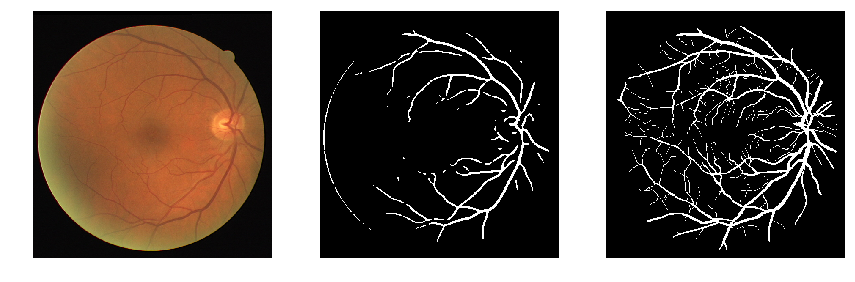

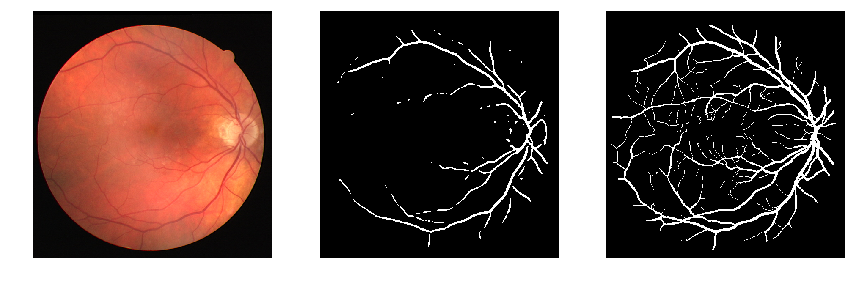

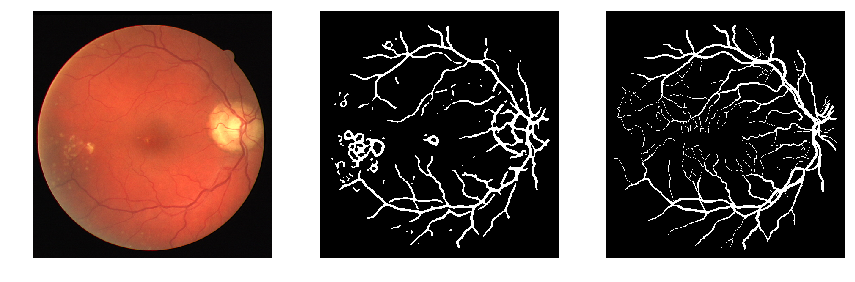

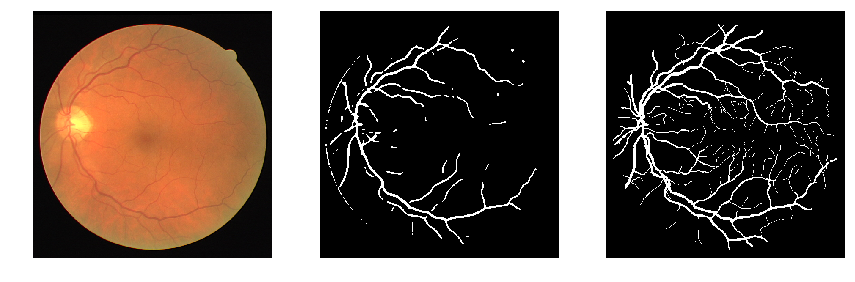

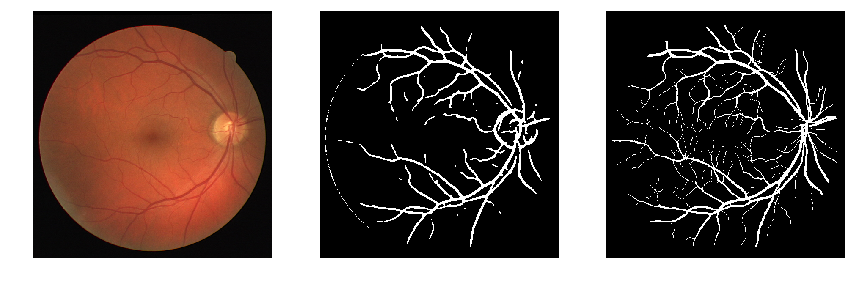

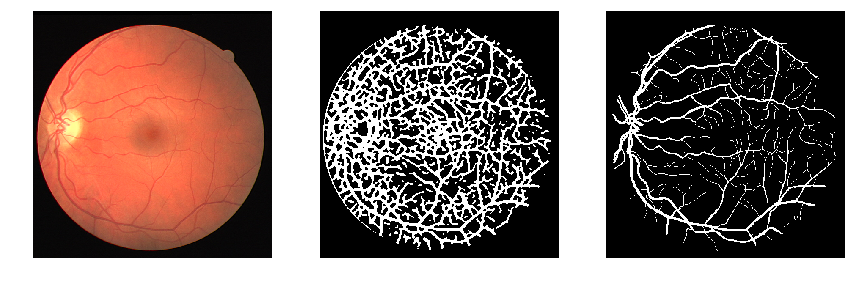

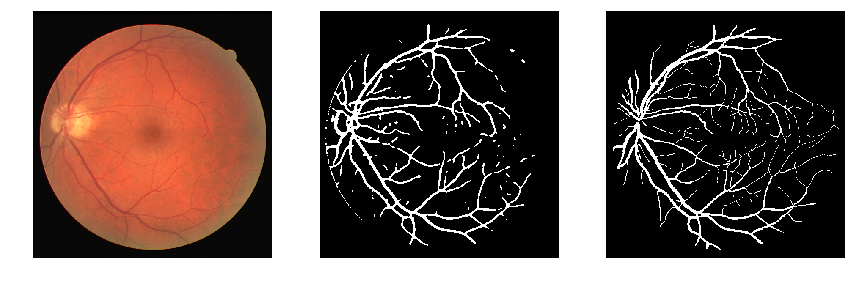

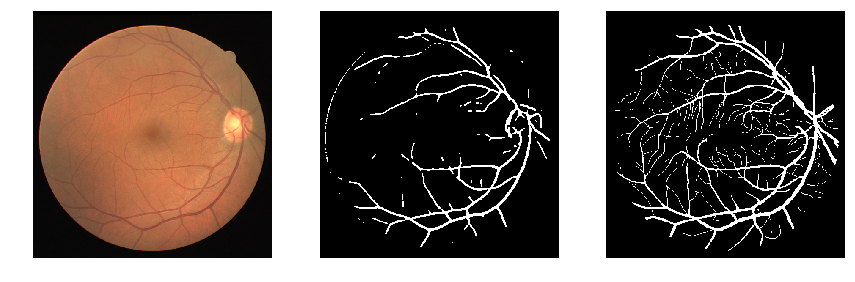

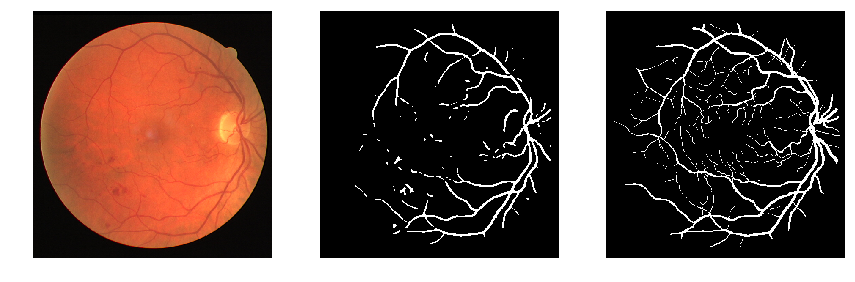

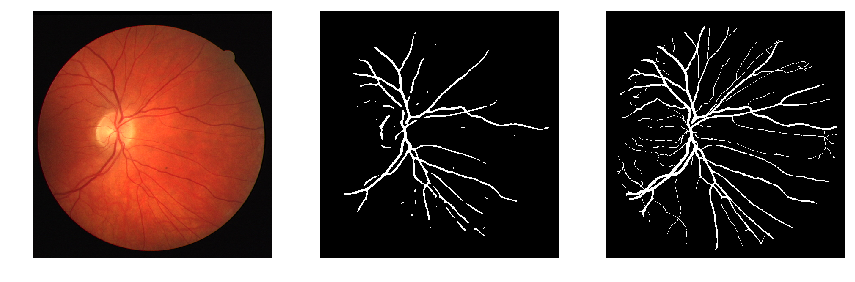

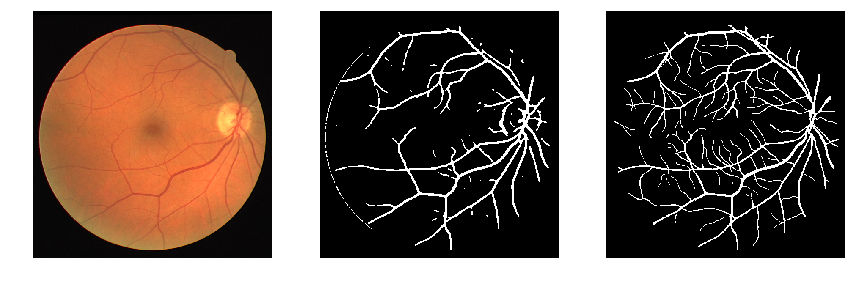

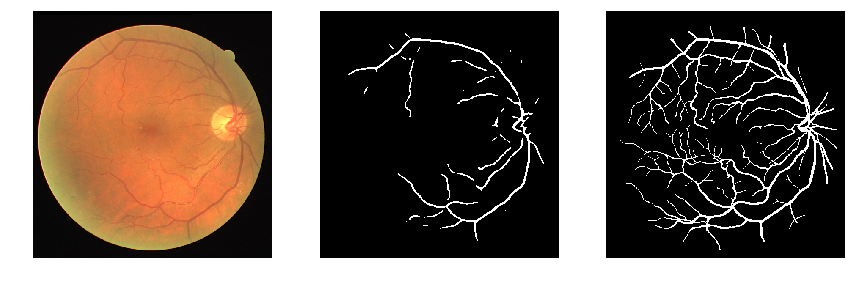

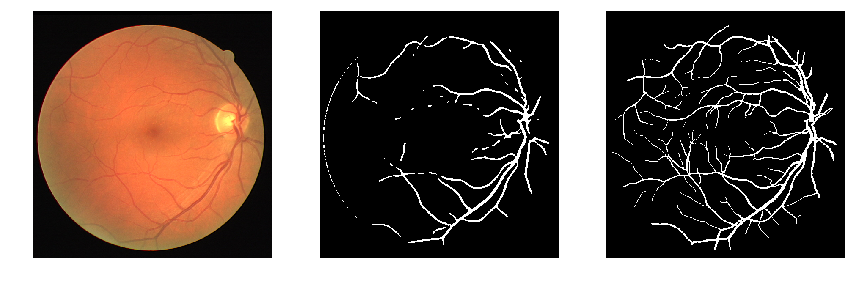

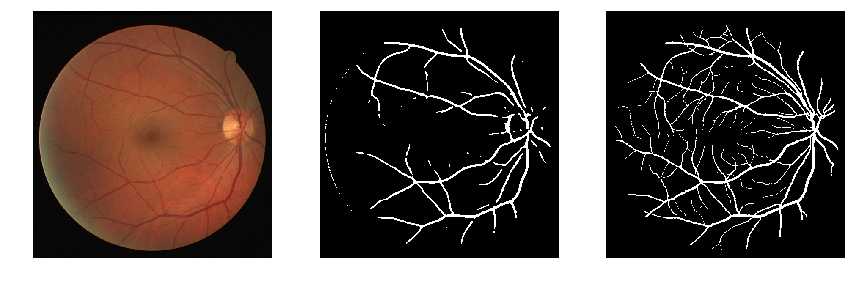

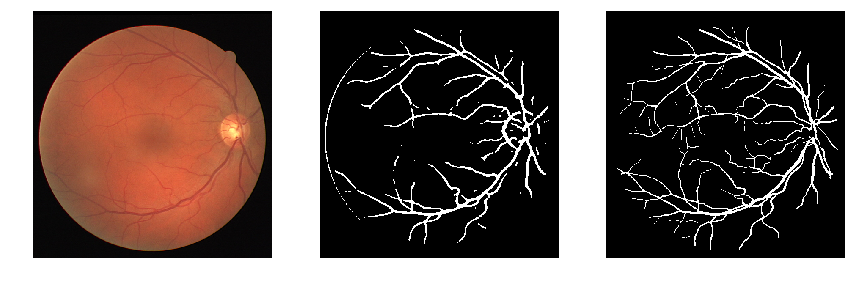

In [22]:
truth = []
pred = []

for i in range(1,21):
    if i < 10:
        t,l,acc = process_img('data/DRIVE/test/images/0' + str(i) + '_test.tif','data/DRIVE/test/mask/0' + str(i) + '_test_mask.gif','data/DRIVE/test/1st_manual/0' + str(i) + '_manual1.gif')
        pred.append(t)
        truth.append(l)
    else:
        t,l,acc = process_img('data/DRIVE/test/images/' + str(i) + '_test.tif','data/DRIVE/test/mask/' + str(i) + '_test_mask.gif','data/DRIVE/test/1st_manual/' + str(i) + '_manual1.gif')
        pred.append(t)
        truth.append(l)


In [41]:
flattened_truth = np.array(truth).flatten()
flattened_pred = np.array(pred).flatten()

from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

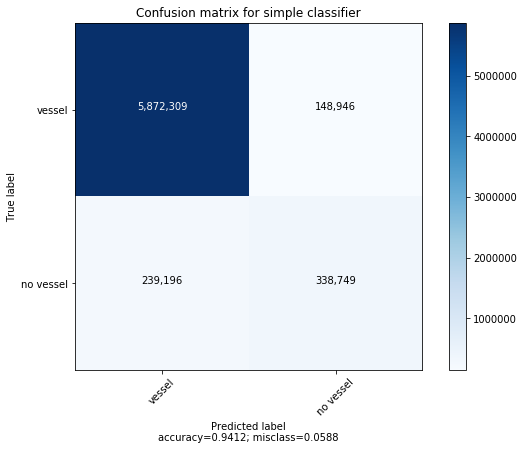

In [48]:
cm = confusion_matrix(flattened_truth,flattened_pred)

plot_confusion_matrix(cm=cm, target_names=['vessel', 'no vessel'], normalize=False,
                      title='Confusion matrix for simple classifier')